In [1]:
import os
import h5py
import faiss
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
seed = 0
path = "../data/tables/20250110/specdiff.h5"
rng = np.random.default_rng(seed)

In [3]:
pf_emb_table = os.path.join(path)
if os.path.isfile(pf_emb_table):
    with h5py.File(pf_emb_table, "r") as f:
        emb_table = pd.DataFrame(
            list([e] for e in f["embeddings"]),
            index=[str(name[0], "utf-8") for name in f["filenames"]],
            columns=["embeddings"],
        )
emb_table["normed_embeddings"] = emb_table["embeddings"].apply(
    lambda x: x / np.linalg.norm(x)
)
print(emb_table.head())

                                                                         embeddings  \
20231220-080-01_0000-0005_t00s00  [-0.053769037, -0.13694727, 0.061716847, 0.084...   
20231220-080-01_0005-0011_t00s00  [-0.057366654, -0.12334323, 0.057373736, 0.101...   
20231220-080-01_0011-0017_t00s00  [-0.055338886, -0.14652249, 0.06530251, 0.0786...   
20231220-080-01_0017-0023_t00s00  [-0.045787167, -0.11423969, 0.087408744, 0.082...   
20231220-080-01_0023-0029_t00s00  [-0.054149292, -0.11939049, 0.07611654, 0.0770...   

                                                                  normed_embeddings  
20231220-080-01_0000-0005_t00s00  [-0.019927025, -0.05075322, 0.022872515, 0.031...  
20231220-080-01_0005-0011_t00s00  [-0.02097576, -0.045099683, 0.020978348, 0.037...  
20231220-080-01_0011-0017_t00s00  [-0.020351348, -0.0538849, 0.024015559, 0.0289...  
20231220-080-01_0017-0023_t00s00  [-0.016738767, -0.041763484, 0.031954687, 0.03...  
20231220-080-01_0023-0029_t00s00  [-0.019924775

In [4]:
faiss_index = faiss.IndexFlatIP(768)
faiss_index.add(
    np.array(emb_table["embeddings"].to_list(), dtype=np.float32)
)  # type: ignore

In [5]:
q_embedding = np.array(
    [emb_table.loc["20231220-080-01_0000-0005_t00s00", "embeddings"]],
    dtype=np.float32,
)

# print(f"{self.tag} querying with key '{q_key}'")
similarities, indices = faiss_index.search(q_embedding, 10)
indices, similarities = zip(
    *[
        (i, s)
        for i, s in zip(indices[0], similarities[0])
        if str(emb_table.index[i]).endswith("s00")
    ]
)
nearest_neighbors = {}
for i, s in zip(indices, similarities):
    nearest_neighbors[str(emb_table.index[i])] = float(s)
nearest_neighbors

{'20231220-080-01_0011-0017_t00s00': 7.305689811706543,
 '20231220-080-01_0005-0011_t00s00': 7.293644428253174,
 '20231220-080-01_0000-0005_t00s00': 7.280808448791504,
 '20231220-080-01_0017-0023_t00s00': 7.277745246887207,
 '20231220-080-01_0023-0029_t00s00': 7.27194881439209,
 '20231220-080-01_0065-0071_t00s00': 6.739600658416748,
 '20231228-072-01_0059-0066_t00s00': 6.636743068695068,
 '20231220-080-01_0071-0077_t00s00': 6.39804744720459,
 '20231220-080-01_0029-0035_t00s00': 6.31468391418457,
 '20240511-088-01_0229-0234_t00s00': 6.280410289764404}

nearest segments from different tracks are:
['20231228-072-01_0059-0066_t00s00', '20240511-088-01_0229-0234_t00s00', '20240305-050-03_0000-0009_t00s00', '20240511-088-01_0283-0289_t00s00', '20240511-088-01_0218-0223_t00s00', '20240511-088-01_0212-0218_t00s00', '20240511-088-03_0158-0163_t00s00', '20240511-088-01_0147-0152_t00s00', '20240511-088-01_0207-0212_t00s00', '20240117-064-05_0000-0007_t00s00']


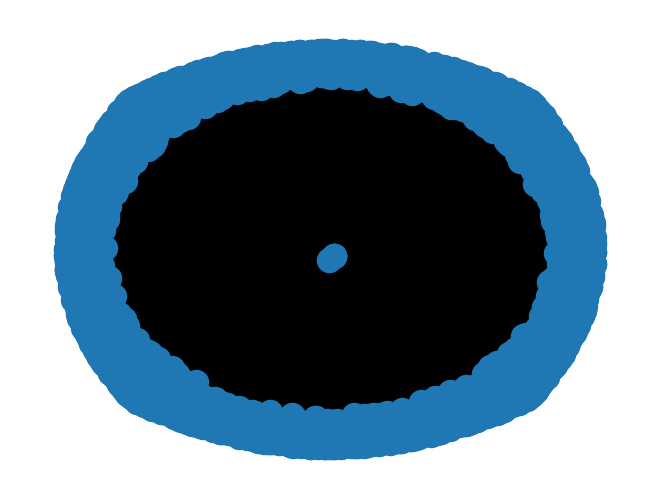

ValueError: Contradictory paths found: negative weights?

In [ ]:
def find_cheapest_paths(input_file, dataframe, faiss_index):
    """
    Finds the 10 nearest files with different TRACK values and computes the cheapest paths to each.

    Args:
        input_file (str): The input filename in the format "TRACK_SEGMENT_TRANSFORM".
        dataframe (pd.DataFrame): A pandas DataFrame with filenames as index and a "embeddings" column containing 768-element vectors.
        faiss_index (IndexFlatIP): A FAISS index for fast similarity searches.

    Returns:
        dict: A dictionary where keys are filenames and values are the cheapest path and its cost.
    """
    # extract the TRACK value from the input file
    input_track = input_file.split("_")[0]

    # get the embedding of the input file
    input_embedding = (
        dataframe.loc[input_file, "embeddings"].astype(np.float32).reshape(1, -1)
    )

    # find the 50 nearest neighbors (for redundancy, filter later by TRACK)
    _, indices = faiss_index.search(input_embedding, 50)

    # map indices back to filenames
    neighbor_files = dataframe.index[indices.flatten()].tolist()

    # filter neighbors by TRACK value to ensure different TRACKs
    filtered_neighbors = [
        file for file in neighbor_files if file.split("_")[0] != input_track
    ]

    # limit to the 10 nearest neighbors with different TRACKs
    nearest_files = list(set(filtered_neighbors))[:10]
    print(f"nearest segments from different tracks are:\n{nearest_files}")

    # build a graph where nodes are filenames and edges are costs based on similarity
    graph = nx.Graph()

    # add nodes and weighted edges based on 1 - similarity
    for i, file1 in enumerate(dataframe.index):
        embedding1 = dataframe.loc[file1, "embeddings"].astype(np.float32)
        for j, file2 in enumerate(dataframe.index):
            if i != j:
                embedding2 = dataframe.loc[file2, "embeddings"].astype(np.float32)
                similarity = np.dot(embedding1, embedding2)  # cosine similarity
                cost = 1 - similarity
                graph.add_edge(file1, file2, weight=cost)

    # nx.draw(graph)
    # plt.show()

    # find the cheapest paths to the 10 nearest files
    paths_and_costs = {}
    for neighbor in nearest_files:
        path = nx.shortest_path(
            graph, source=input_file, target=neighbor, weight="weight"
        )
        cost = nx.shortest_path_length(
            graph, source=input_file, target=neighbor, weight="weight"
        )
        paths_and_costs[neighbor] = {"path": path, "cost": cost}

    return paths_and_costs


# example usage (requires actual data):
paths = find_cheapest_paths("20231220-080-01_0000-0005_t00s00", emb_table, faiss_index)
print(paths)